## Notes about the mesh xxxx
* This mesh uses elements of 20 m in the vicinity of fault, and gets coarser (100 m) at off-fault distances.

* nel = 14,220

* CFL is changed to 0.5

* Code is the latest version of Chao's, with fixes of round-off errors

## Conclusion
* Noisy (non-smooth) after stress upon the 1st dynamic event
* No error, but the 2nd event looks like a numerical instability--> fixed when using hnodescale=0.5 or 0.25.
* Checking if 7 cycles are stable.

In [1]:
%matplotlib notebook

import sys
import matplotlib.pyplot as plt
sys.path.append('/Users/elifo/Work/Soft/sem2dpack/JUPYTER/')
sys.path.append('/Users/elifo/Work/Soft/sem2dpack/JUPYTER/modules/')

from Class_sem2dpack import *

# Read outputs

In [2]:
# Create class with the simulation directory
# path-to-simulation-directory
_dir = '../RateState_testing_josephs_13Lnuc_debug_dtevol2//'
# _dir = '../RateState_testing_josephs_13Lnuc_test_codeversion/'



# init class
SEM = sem2dpack(_dir, read_header=False)


# Model coordinates
x, z = SEM.mdict['coord'][:,0],  SEM.mdict['coord'][:,1]

# x.shape, z.shape
# x: along dip (for strike-slip here)

Reading grid information...
*


In [3]:
# remove problem line
problematic_line = 101068

self = SEM
fname = self.directory+'/Flt'+str('%02d' % 3)+'_time_sem2d.tab'  
with open(fname, "r") as f:
    lines = f.readlines()
len(lines)
dummy = lines[problematic_line-1].split()
sep = '\t'
string = dummy[0]+sep+dummy[1]+sep+lines[problematic_line-2].split()[2]+sep+'4 T F F'+'\n'
lines[problematic_line-1] = string

with open(fname, "w") as f:
    for line in lines:
        f.write(line)
###

In [4]:
SEM.read_fault(is_rate_and_state=True)

Fault boundary:  [3]
Guessed array size, nsamp:  127001.0
Assigning  Slip
Assigning  Slip_Rate
Assigning  Shear_Stress
Assigning  Normal_Stress
Assigning  Friction
Assigning  theta
../RateState_testing_josephs_13Lnuc_debug_dtevol2////Flt03_time_sem2d.tab


In [5]:
SEM.fault['Slip_Rate'].shape, SEM.fault['t'].shape
veloc = SEM.fault['Slip_Rate']

# eq = 1
# cdt = ( self.fault['#EQ'] == float(eq)) & (self.fault['isEq']== True)
# self.fault['it'][cdt]

In [6]:
its = []
dynamic= False
_its = []
for it in range(veloc.shape[1]):
    
    _velo = veloc[:,it]
    
    if max(_velo) >= 5e-3:
        _its.append(it)
        dynamic=True
    if dynamic and max(_velo) <= 2e-3:
        dynamic=False
        its.append(_its)
        _its = []

In [7]:
len(its)

4

# Plot time step evolution

<IPython.core.display.Javascript object>


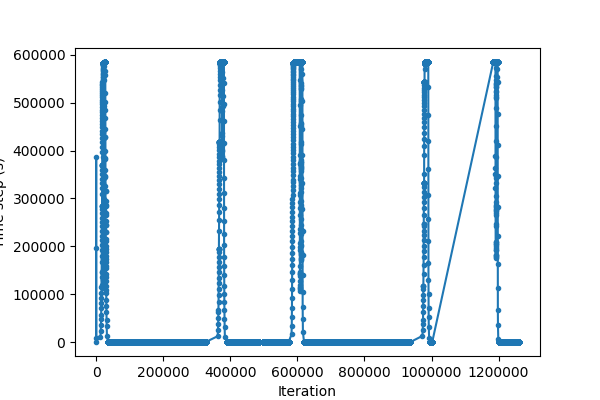

Min time step (s):  0.00012461977817981266
Max time step (s):  585033.4143999062


In [8]:
SEM.plot_cycles_time_step()

<IPython.core.display.Javascript object>


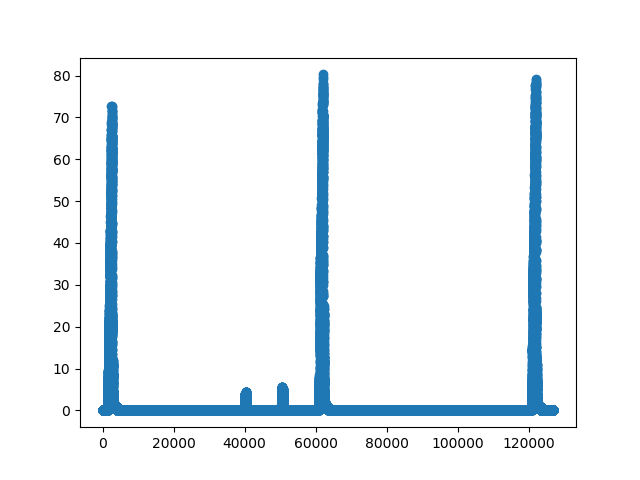

In [9]:
Vmax = veloc.max(axis=0)
its = np.arange(len(Vmax))
plt.scatter(its, Vmax)


<IPython.core.display.Javascript object>


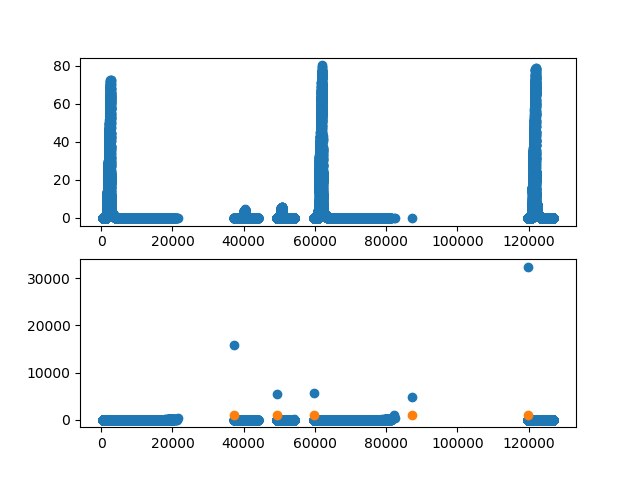

In [10]:
np.where(Vmax >=5e-3), np.where(Vmax <=2e-3)
cdt = np.where(Vmax >=5e-3)


cdt2 = (np.diff(its[cdt])>1000)
switches = its[cdt][1:][cdt2]
switches


plt.subplot(211)
plt.scatter(its[cdt][1:], Vmax[cdt][1:])


plt.subplot(212)
plt.scatter(its[cdt][1:], np.diff(its[cdt]))
plt.scatter(switches, [1000 for s in switches])

In [11]:
switches


array([ 37381,  49340,  59783,  87292, 119758])

In [12]:
def plot_slip_rate_debugging_weird_file(it1=0, it2=switches[0], eq=1):
    _veloc = veloc[:, it1:it2]
    xx = its[it1:it2]


    self = SEM
    VW_halflen = 1900
    _vmin, _vmax = 0.0, 2.0
    V = _veloc
    # Shear stress: beginning vs end
    init = self.fault['Shear_Stress'][:,it1:it2][:,0] /1e6
    final = self.fault['Shear_Stress'][:,it1:it2][:,-1]/ 1e6

    init += self.fault['st0']/1e6
    final += self.fault['st0']/1e6

    # SLIP RATE
    data = V
    print ('Max slip rate: ', max(V.flatten()))


    yy = self.fault['x']
    #


    ### Plot
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, sharey=True)

    ###
    ax = axs[0]
    ax.set_title('Shear stress (MPa)')
    ax.set_ylabel('Along dip (m)')
    xmin, xmax = min(min(init), min(final)), max(max(init), max(final))
    ax.set_ylim(-2*VW_halflen, 2*VW_halflen)
    ax.hlines(y=VW_halflen, xmin=xmin, xmax=xmax, linestyle=':')
    ax.hlines(y=-VW_halflen, xmin=xmin, xmax=xmax, linestyle=':')
    ax.plot(init, yy, c='k', label='Initial stress')
    ax.plot(final, yy, c='red', label='Final stress')
    ax.grid()

    ###
    ax = axs[1]
    ax.set_title('Slip rate for event #'+ str(eq))
    ext = [min(xx), max(xx), min(yy), max(yy)]
    xmin, xmax = min(xx), max(xx)
    ax.hlines(y=VW_halflen, xmin=xmin, xmax=xmax, linestyle=':')
    ax.hlines(y=-VW_halflen, xmin=xmin, xmax=xmax, linestyle=':')
    im = ax.imshow(data, extent=ext,
             interpolation='nearest', cmap='rainbow', aspect='auto', vmin=_vmin, vmax=_vmax, origin='lower')
    ax.set_xlabel('t (s)')
    cb = fig.colorbar(im, orientation='vertical')
    cb.set_label('V')
    fig.set_size_inches(9.0, 4.5)
    plt.tight_layout()
###




Max slip rate:  72.72639


<IPython.core.display.Javascript object>


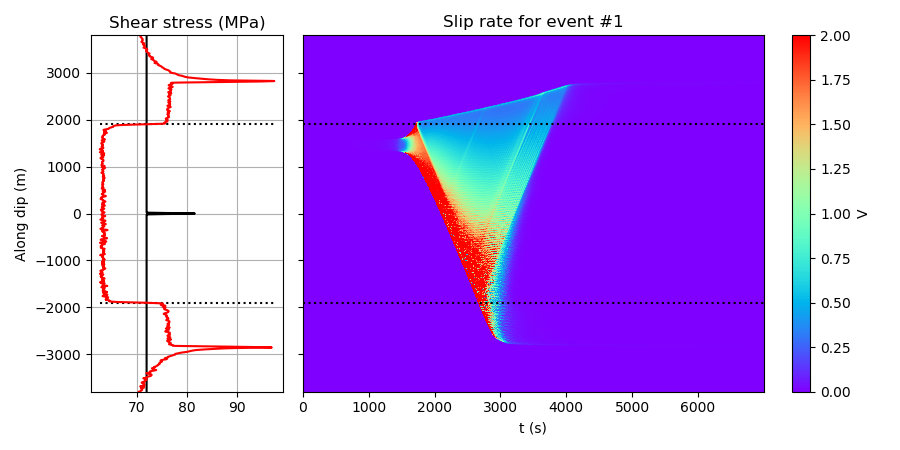

In [14]:
plot_slip_rate_debugging_weird_file(it1=0, it2=7000, eq=1)

Max slip rate:  4.4533443


<IPython.core.display.Javascript object>


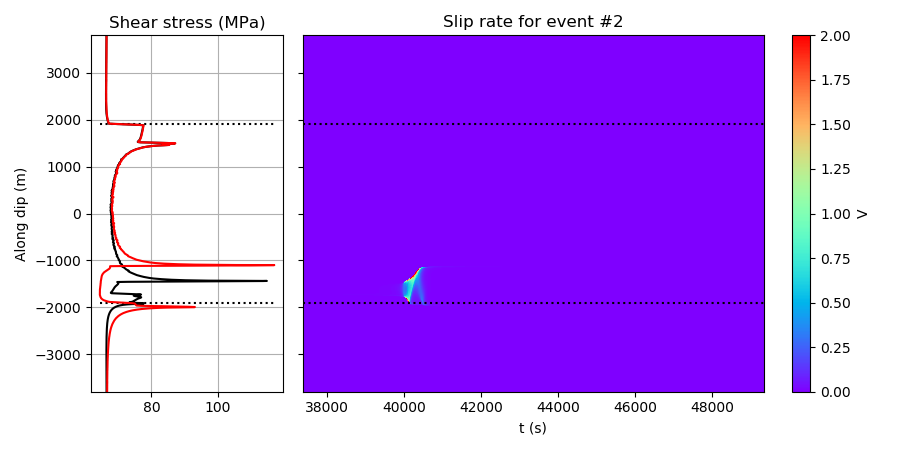

In [19]:
plot_slip_rate_debugging_weird_file(it1=switches[0], it2=switches[1], eq=2)

Max slip rate:  5.6010394


<IPython.core.display.Javascript object>


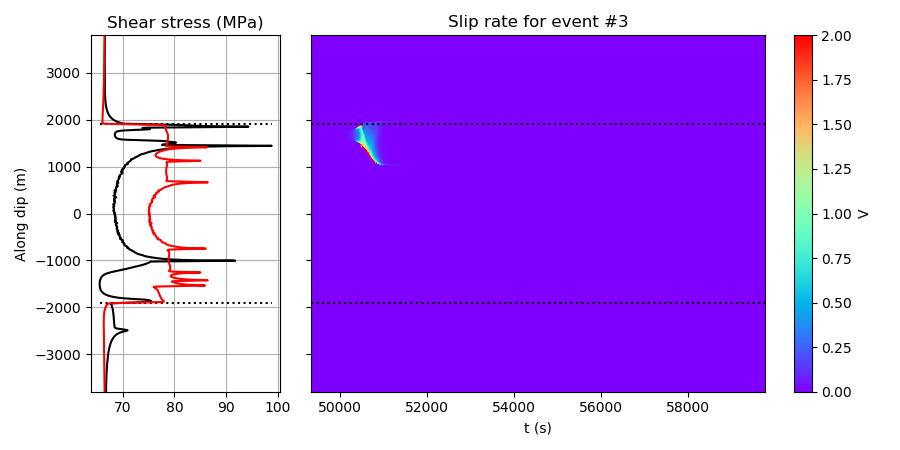

In [21]:
plot_slip_rate_debugging_weird_file(it1=switches[1], it2=switches[2], eq=3)

Max slip rate:  80.27573


<IPython.core.display.Javascript object>


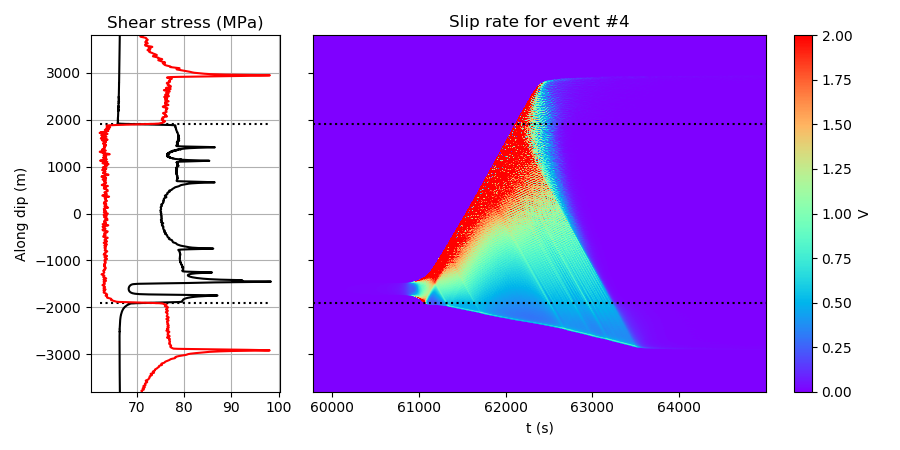

In [23]:
plot_slip_rate_debugging_weird_file(it1=switches[2], it2=65000, eq=4)

Max slip rate:  0.0050062495


<IPython.core.display.Javascript object>


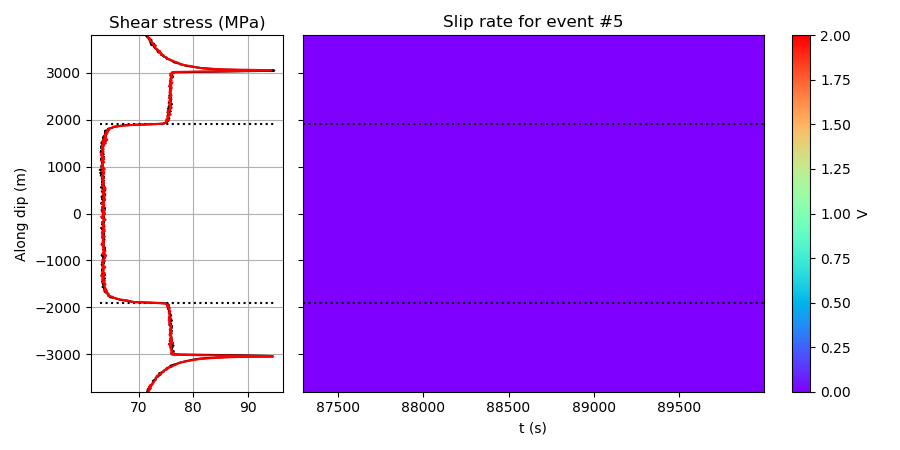

87292


In [26]:
plot_slip_rate_debugging_weird_file(it1=switches[3], it2=90000, eq=5)
print (switches[3])

Max slip rate:  79.10288


<IPython.core.display.Javascript object>


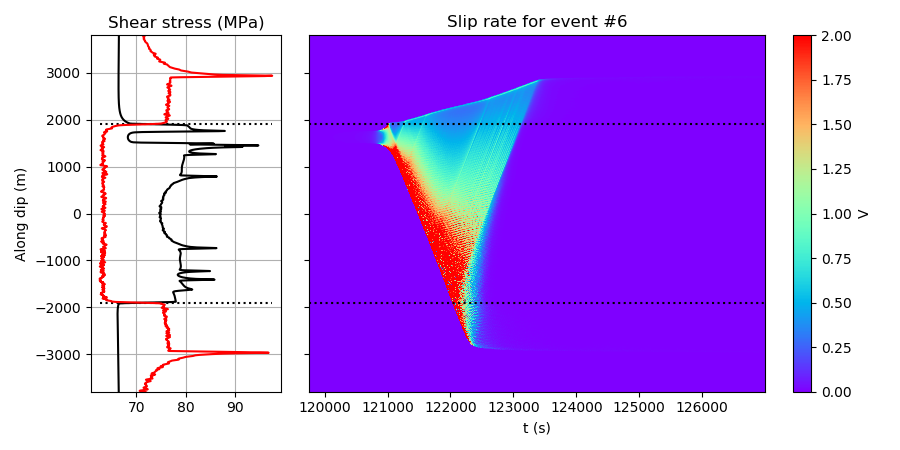

In [27]:
plot_slip_rate_debugging_weird_file(it1=switches[4], it2=its[-1], eq=6)